# DT: Drug Prescriber

## Reading CSV File

In [1]:
import pandas as pd

df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


## Preprocessing Data

Scaling our data is not required in tree-based algorithms, but we still need to convert all our independent variables into a numerical format.

In [2]:
df.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

### Label Encoding

In [3]:
for column in df:
    if df[column].dtype == object:
        print(column + ":", df[column].unique())

Sex: ['F' 'M']
BP: ['HIGH' 'LOW' 'NORMAL']
Cholesterol: ['HIGH' 'NORMAL']
Drug: ['drugY' 'drugC' 'drugX' 'drugA' 'drugB']


In [4]:
from sklearn.preprocessing import LabelEncoder

for column in df:
    if column == "Sex" or column == "BP" or column == "Cholesterol":
        encoder = LabelEncoder()
        encoder.fit(df[column].unique())
        df[column] = encoder.transform(df[column])
        df[column] = df[column].astype('category')
        
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,drugY
1,47,1,1,0,13.093,drugC
2,47,1,1,0,10.114,drugC
3,28,0,2,0,7.798,drugX
4,61,0,1,0,18.043,drugY


We change the type of the column to "category" to avoid the `.describe()` method calculating the mean/std/quartiles of that column.

In [5]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


## Defining Attributes and Label

In [18]:
label = "Drug"

X = df.drop([label, "Sex", "Cholesterol"], axis=1)
y = df[label]

## Visualing Class Imbalance

As you can see, DrugY has a high majority in our dataset, and DrugA and DrugB are the lowest, which shows that that we will need to cater to this imbalance by
1) using `stratify` to ensure the split of each category in our datasets is equal
2) using a `weighted` paramater in our `f1_score`

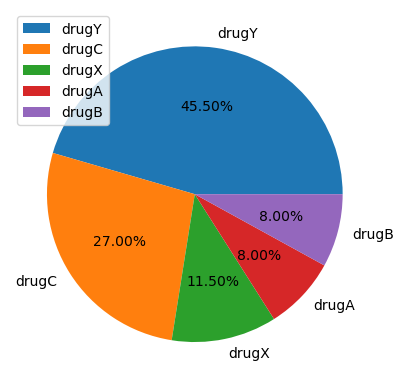

In [19]:
import matplotlib.pyplot as plt

labels = df[label].unique()
sizes = df[label].value_counts().values

plt.pie(sizes, labels = labels, autopct='%.2f%%')
plt.legend()
plt.show()

## Splitting Dataset into Train-Test Sets

There is no need to scale our features in a Decision Tree, so we simply will not.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Training Decision Tree Model

In [26]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import f1_score

best_depth = 0
best_score = 0

for x in range(1, len(X_train.columns)+1):
    drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = x)
    drugTree.fit(X_train, y_train)
    
    y_pred = drugTree.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='weighted')
    print(x, ": ", f1)

    if f1 > best_score:
        best_score = f1
        best_depth = x

1 :  0.6333333333333333
2 :  0.7881538461538462
3 :  0.8586631016042781


As `max_depth=4` gives the best output, we will proceed with that.

In [27]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = best_depth)
drugTree.fit(X_train, y_train)

y_pred = drugTree.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

F1 Score: 0.8586631016042781


In [28]:
features = pd.DataFrame(drugTree.feature_importances_, index = X.columns)
features.head()

,0
Age,0.105226
BP,0.344301
Na_to_K,0.550473


The `feature_importances_` shows us the impact of each independent variable on our tree. On a larger dataset, to avoid overfitting, we might need to prune certain nodes that have minimal impact on our tree (e.g. by adding `ccp_alpha` to our `DecisionTreeClassifier()`; in our case, adding a `ccp_alpha` of 0.136 or below has no impact on our model, and increasing it reduces our accuracy, so we choose to forego it entirely.)

Before, `Sex` was `0`, so we removed it. Then `Cholesterol` was also `0`, so we removed it. 

## Evaluating Model

In [30]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred, zero_division=0))

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average='weighted').round(3))

              precision    recall  f1-score   support

       drugA       0.83      1.00      0.91         5
       drugB       1.00      0.67      0.80         3
       drugC       0.38      1.00      0.55         3
       drugX       1.00      0.55      0.71        11
       drugY       1.00      1.00      1.00        18

    accuracy                           0.85        40
   macro avg       0.84      0.84      0.79        40
weighted avg       0.93      0.85      0.86        40

Accuracy:  0.85
F1:  0.859


In [33]:
from sklearn import tree 

print(tree.export_text(drugTree))

|--- feature_2 <= 14.84
|   |--- feature_1 <= 0.50
|   |   |--- feature_0 <= 52.00
|   |   |   |--- class: drugA
|   |   |--- feature_0 >  52.00
|   |   |   |--- class: drugB
|   |--- feature_1 >  0.50
|   |   |--- feature_1 <= 1.50
|   |   |   |--- class: drugC
|   |   |--- feature_1 >  1.50
|   |   |   |--- class: drugX
|--- feature_2 >  14.84
|   |--- class: drugY



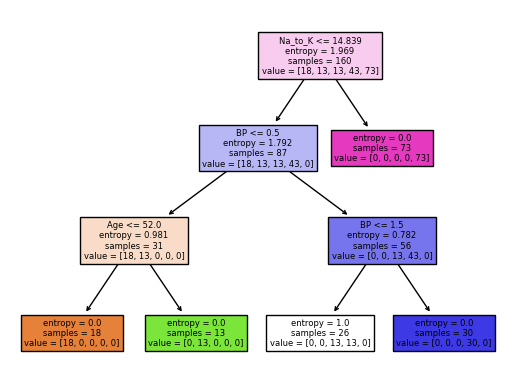

In [34]:
import matplotlib.pyplot as plt

feature_names = X.columns

tree.plot_tree(drugTree, feature_names=feature_names, filled=True)
plt.show()